<a href="https://colab.research.google.com/github/Floquicanale/TP-2-PSB/blob/main/Prueba_offline_datos1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from ipaddress import summarize_address_range
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
arch_path = '/content/drive/MyDrive/TPS PSB/datos1.csv'
datos = pd.read_csv(arch_path)

In [4]:
D2 = datos.to_numpy()
Fs= 250

In [5]:

class Pan_Tom_QRS():

    def pasabanda(x):
        '''
    Filtro PasaBnada
    :param signal: señal de entrada
    :return: señal procesada

    Metodología:
    Usamos un filtro pasabanda para atenuar el ruido.
    Necesitamos solo las señales con frecuencia de 5 a 15 Hz,
    para quedarnos con estas primero usamos un pasabajos y luego un pasaaltos en cadena.

    Ecuacion recursiva del pasabajos:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    Ecuacion recursiva del pasaaltos:
      y(nT) = 32x(nT - 16T) - [y(nT - T) + x(nT) - x(nT - 32T)]

      fuente: https://www.robots.ox.ac.uk/~gari/teaching/cdt/A3/readings/ECG/Pan+Tompkins.pdf
      El corte inferior es de 5Hz el superior en 11 Hz la ganancia de 32 para el pasaaltos y 36 pasabajos.
    '''
        # El resultado empieza siendo nada
        result = None

        # La copia de la señal va a ser y
        y = x.copy()

        # Aplicamoes el pasabajos de segundo orden
        for index in range(len(x)):
            y[index] = x[index] #vendria a ser la parte del x(nT)

            if (index >= 1):
                y[index] += 2*y[index-1] #primer termino

            if (index >= 2):
                y[index] -= y[index-2] #segundo

            if (index >= 6):
                y[index] -= 2*x[index-6] #cuerto

            if (index >= 12):
                y[index] += x[index-12] #ultimo

        result = y.copy()
        # Aplicamos el filtro pasaaltos
        for index in range(len(x)):
            result[index] = -1*y[index] #vendria a ser el -x(nT)

            if (index >= 1):
                result[index] -= result[index-1]

            if (index >= 16):
                result[index] += 32*y[index-16]

            if (index >= 32):
                result[index] += y[index-32]

        # Normalizando el valor de la salida del filtro
        max_val = max(max(result),-min(result))
        result = result/max_val

        return result

    def derivada(x):
        '''
    Filtro Derivativo
    :param signal: señal de entrada
    :return: señal derivada

    Metodología:
    Usamos un filtro derivativo de 5 puntos para obtener la pendiente de los picos.
    El gráfico del filtro es lineal hasta los 30 Hz lo que lo
    aproxima a una derivada ideal.

    Ecuacion recursiva del integrador:
      y(nT) = (1/8T)[-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]

      fuente: https://www.robots.ox.ac.uk/~gari/teaching/cdt/A3/readings/ECG/Pan+Tompkins.pdf
      '''

        #Mismo procedimiento que para los otros filtros

        result = x.copy()

        #Aplicamos el filtro
        for index in range(len(x)):
            result[index] = 0 #empieza siendo cero en todas partes

            if (index >= 1):
                result[index] -= 2*x[index-1]

            if (index >= 2):
                result[index] -= x[index-2]

            if (index >=2 and index <= len(x)-3):
                result[index] += x[index+2]

            if (index >=2 and index <= len(x)-2):
                result[index] += 2*x[index + 1]

            result[index] = result[index]/8

        return result

    def cuadrado(x):
        '''
    Elevar al cuadrado
    :param signal: señal de entrada
    :return: señal elevada al cuadrado

    Metodología:
    Se eleva al cuadrado la señal para quedarnos con todos valores positivos

    Ecuacion:
      y(nT) = [x(nT)]^2

      fuente: https://www.robots.ox.ac.uk/~gari/teaching/cdt/A3/readings/ECG/Pan+Tompkins.pdf
      '''

        result = x.copy()

        for index in range(len(x)):
            result[index] = x[index]**2

        return result

    def integrador(x, fs):
        '''
    Integrador de ventana móvil
    :param signal: señal de entrada
    :return: señal integrada

    Metodología:
    La idea es ver la duración de la onda. Por lo general el largo de la ventena debería ser
    aproximadamente el máximo valor del largo de un QRS.
    Hay que buscarlo empíricamente, para el paper usado como bibliografía usan Fs = 200 Hz
    y la ventana de 30 muestras (150 ms).

    Ecuacion de integrador con ventana móvil:
      y(nT) = 1/N [x(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]

      fuente: https://www.robots.ox.ac.uk/~gari/teaching/cdt/A3/readings/ECG/Pan+Tompkins.pdf
      '''
        largo_ventana = 0.150 #esta en segundos chequear empiricamente
        result = x.copy()
        ventana = round(largo_ventana*fs)
        suma = 0

        #calculo de la suma para los primeros N terminos, todavia no alcanza para restar nada
        for i in range(ventana):
            suma += x[i]/ventana
            result[i] = suma

        for index in range(ventana, len(x)):
            suma += x[index]/ventana
            suma -= x[index-ventana]/ventana
            result[index] = suma

        return result

    def resolver(x, fs):

        # Bandpass Filter
        global bpass
        bpass = Pan_Tom_QRS.pasabanda(x.copy())

        # Derivative Function
        global der
        der = Pan_Tom_QRS.derivada(bpass.copy())

        # Squaring Function
        global sqr
        sqr = Pan_Tom_QRS.cuadrado(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = Pan_Tom_QRS.integrador(sqr.copy(), fs)

        return mwin

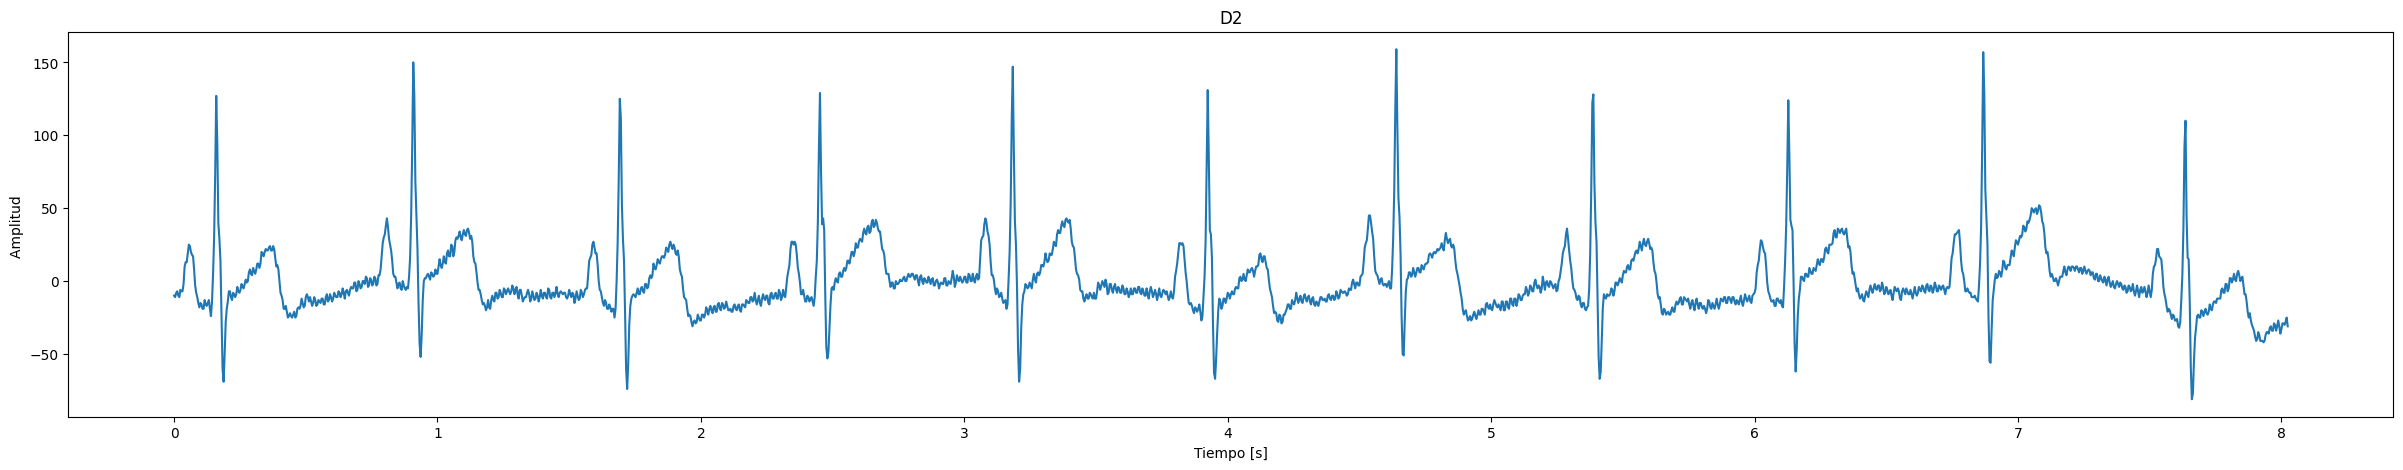

In [6]:
n = np.arange(0,(len(D2))/Fs,1/Fs) #creamos el vector tiempo
t= np.linspace(0, len(D2)/Fs, len(D2))

offset = np.mean(D2)

señal = D2 - offset
'''

for j in range(len(D2)):
  señal[j]=D2[j]-offset
'''

plt.figure(figsize=(30,5))
plt.plot(n,señal)
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

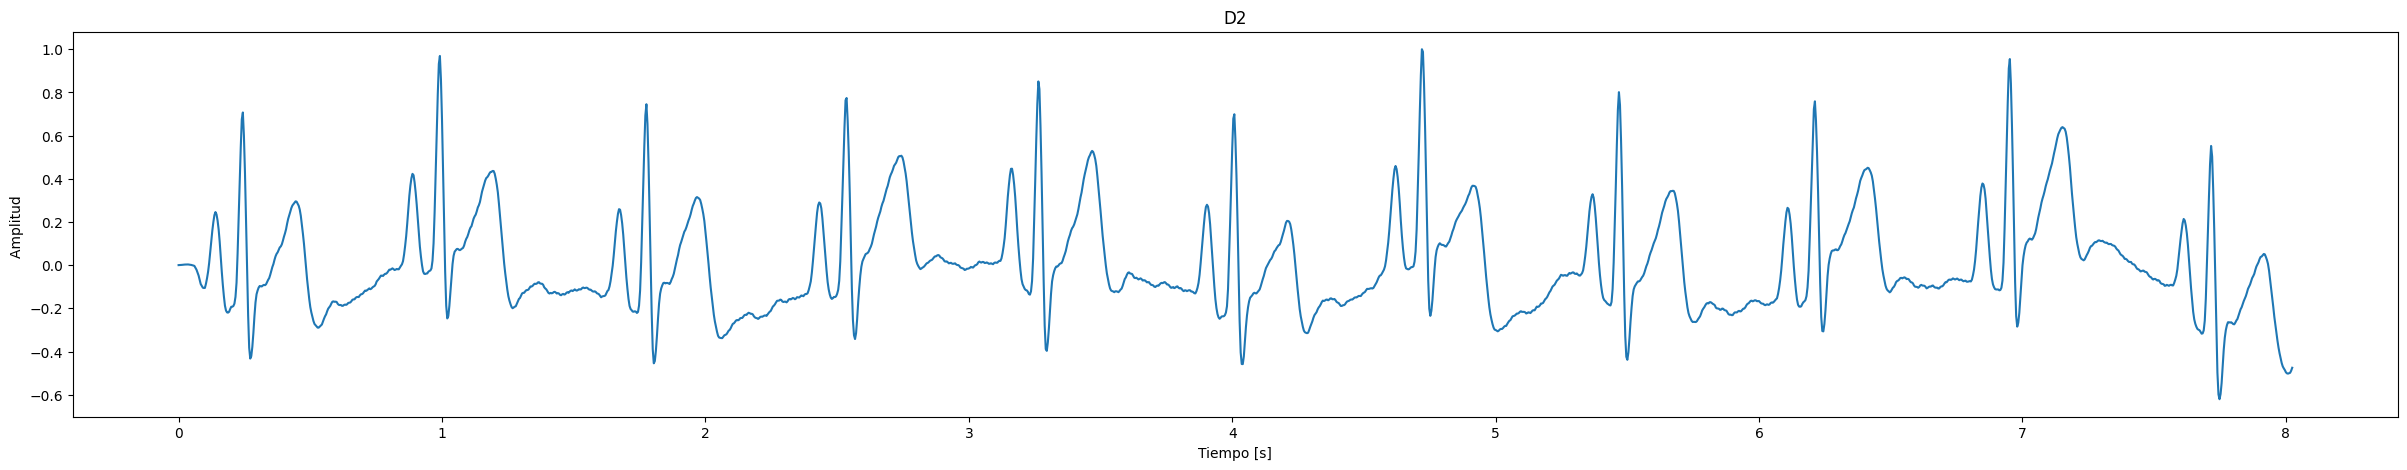

In [7]:
filtrada = Pan_Tom_QRS.pasabanda(señal)
plt.figure(figsize=(30,5))
plt.plot(n,filtrada)
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

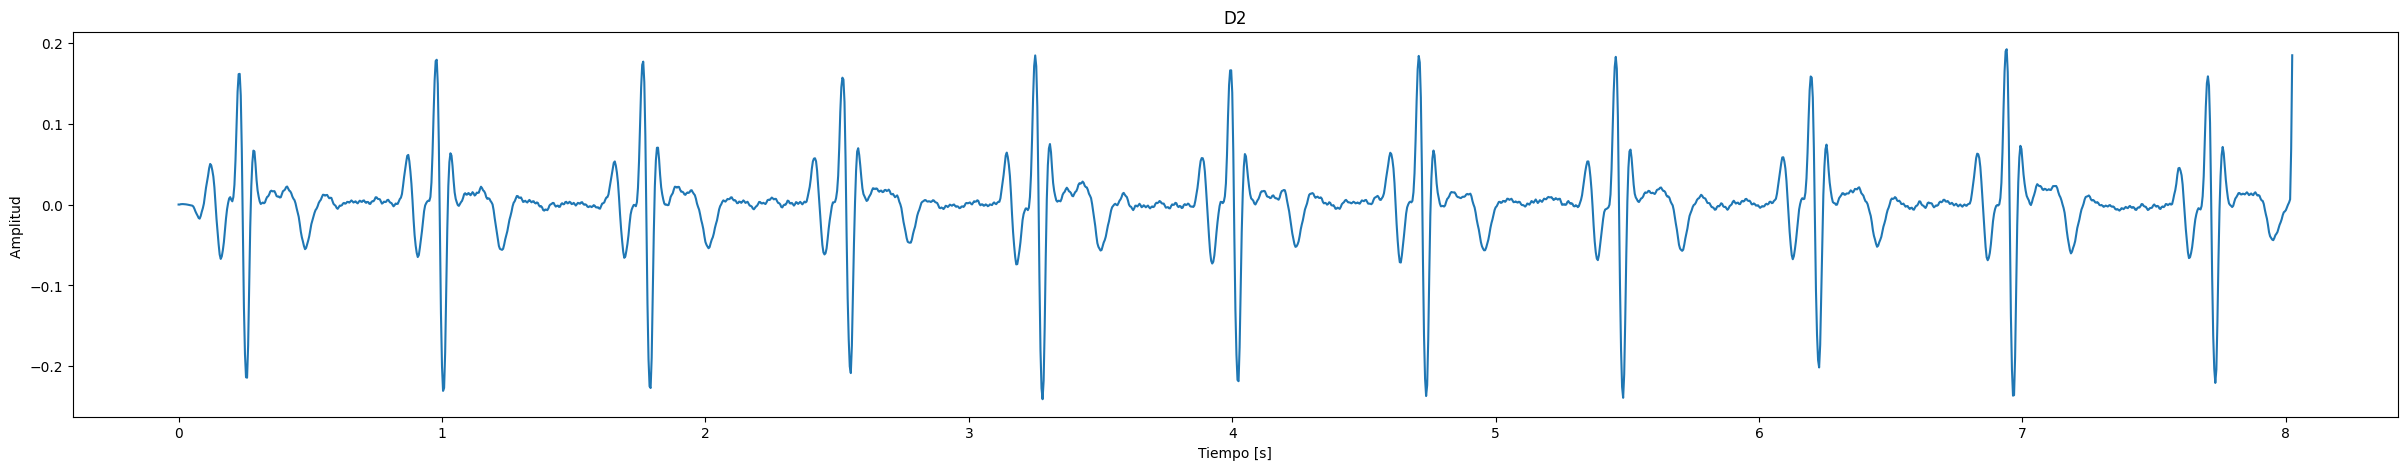

In [8]:
derivada = Pan_Tom_QRS.derivada(filtrada)
plt.figure(figsize=(30,5))
plt.plot(n,derivada)
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

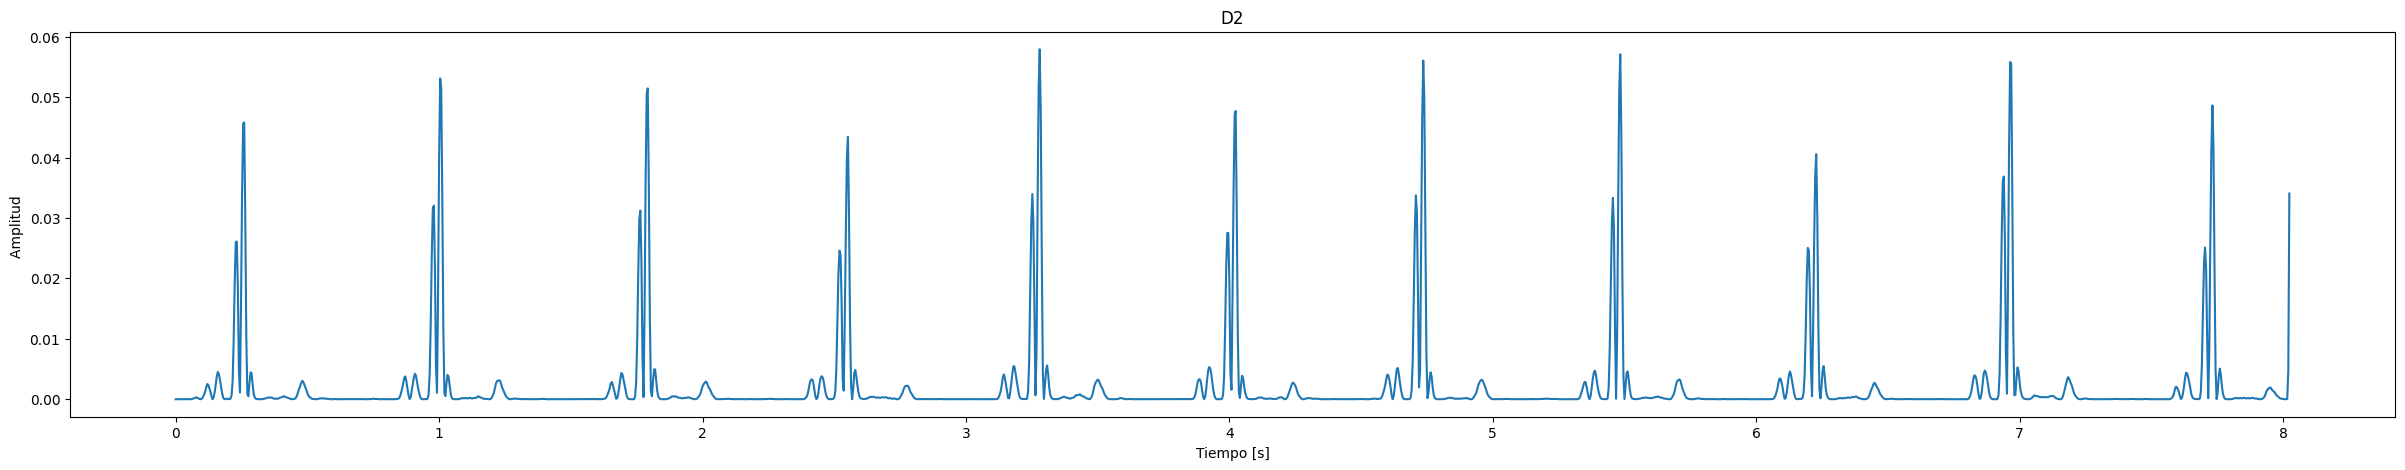

In [9]:
cuadrado = Pan_Tom_QRS.cuadrado(derivada)
plt.figure(figsize=(30,5))
plt.plot(n[0:20*Fs],cuadrado[0:20*Fs])
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

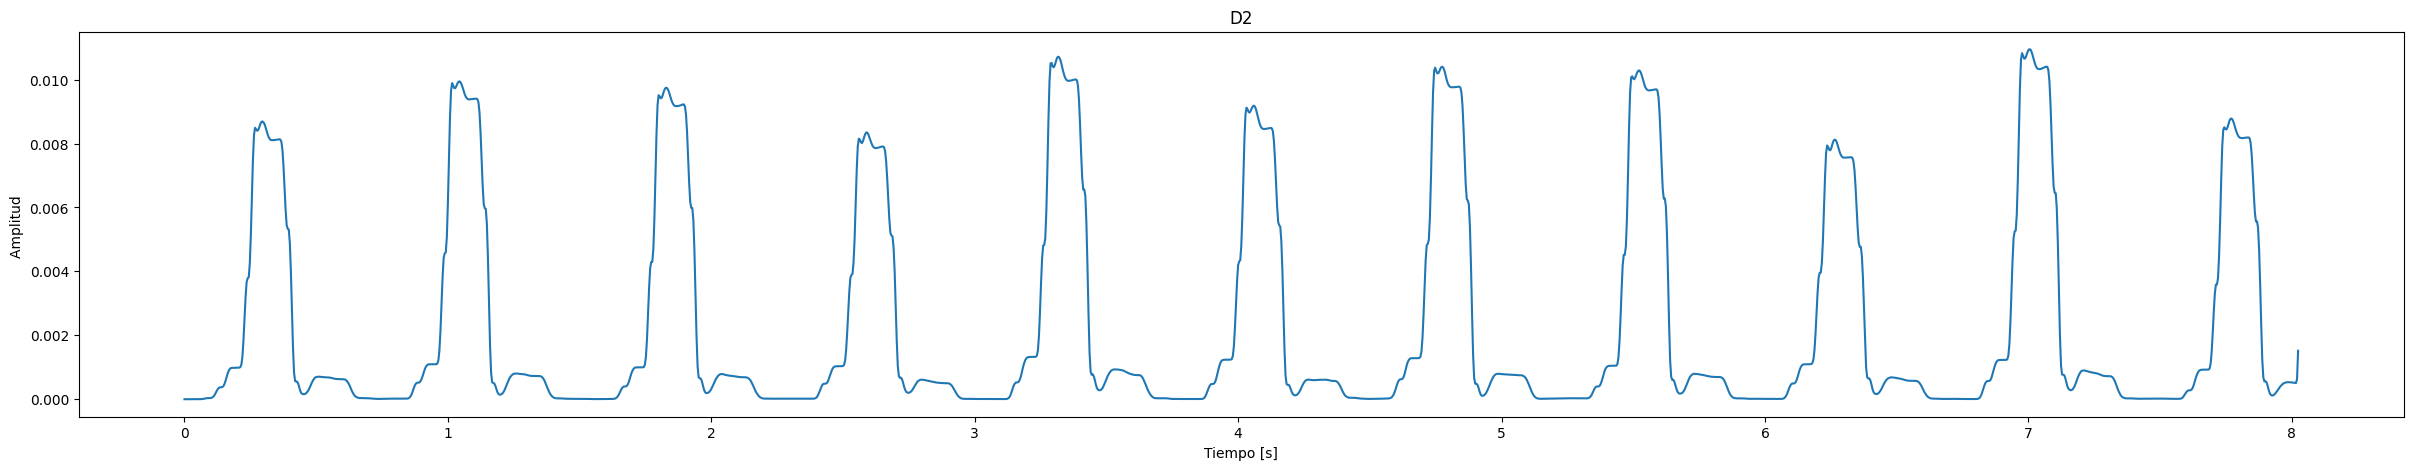

In [10]:
output = Pan_Tom_QRS.integrador(cuadrado, Fs)
plt.figure(figsize=(30,5))
plt.plot(n[0:20*Fs],output[0:20*Fs])
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

In [11]:
output = output.ravel()
output

array([0.00000000e+00, 8.12979993e-11, 4.46858706e-09, ...,
       5.07968715e-04, 6.26266768e-04, 1.51803401e-03])

(array([  74,  261,  457,  647,  829, 1015, 1194, 1380, 1566, 1751, 1943]), {'peak_heights': array([0.00869078, 0.00994651, 0.00974641, 0.00834402, 0.01071648,
       0.00918431, 0.01039913, 0.0102846 , 0.00812214, 0.01095115,
       0.00877884])})


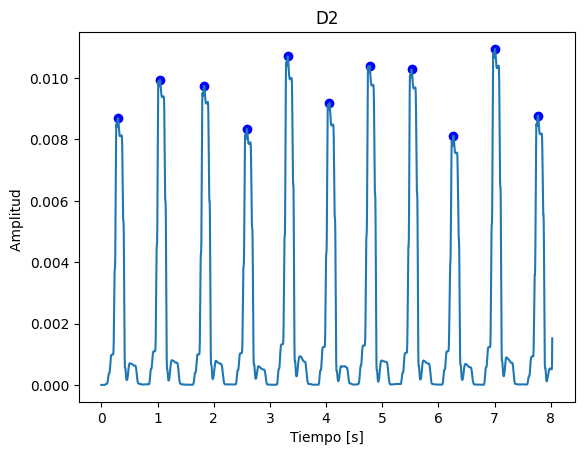

In [12]:
umbral = 0.7*max(output)
# Busco los picos
picos = sp.signal.find_peaks(output, height=umbral, distance=100)
print(picos)

for i in range(len(picos[0])):
  punto = output[picos[0][i]]
  plt.plot(n[picos[0][i]], punto,"o", color="b")

plt.plot(n,output)
plt.title('D2')
plt.ylabel('Amplitud ')
plt.xlabel('Tiempo [s]')
plt.show()

In [13]:
class Cardiac_Freq():
    def frequency(peaks, fs):
        distance = 0
        prom = 0
        for i in range(len(peaks[0])):
            if(i+1<len(peaks[0])):
                distance = peaks[0][i+1]-peaks[0][i]
                prom += distance
        if len(peaks[0])!=1:
          prom = prom/(len(peaks[0])-1)
        print(prom)
        if prom!=0:
          frec = 60/(prom/fs)
        else: frec=0
        return frec

In [14]:
frecuencia = Cardiac_Freq.frequency(picos, Fs)
print(frecuencia)

186.9
80.25682182985554
